## Useful Tips

In this section, we discuss some useful mechanisms provided by simulus to help accomplish modeling tasks.

### Pseudo-Random Numbers

So far we have been using Python's `random` module to generate all the needed pseudo-random numbers in our examples. One can also use `numpy.random` to generate random numbers. Both generators use Mersenne Twister, which has been proven to have very good random properties. Using `numpy.random`, however, has a couple of advantages: one is that it can generate more random distributions; the other is that the numpy random module understands numpy arrays and can be used to generate random numpy arrays quite efficiently. The only downside of using `numpy.random` is that it requires that one installs numpy first (you can use `pip install`). 

The following shows the single-server queue example which we discussed earlier, but at this time, we use different random distributions for the inter-arrival time and the service time. We use a Pareto distribution to sample to the inter-arrival times and use a Gamma distribution to sample the service times.

In [1]:
# %load '../examples/misc/mm1-numpy.py'
import numpy # assuming numpy has been installed
import simulus

numpy.random.seed(123)

def job(idx):
    r.acquire()
    print("%g: job(%d) gains access" % (sim.now,idx))
    sim.sleep(numpy.random.gamma(2, 2))
    print("%g: job(%d) releases" % (sim.now,idx))
    r.release()

def arrival():
    i = 0
    while True:
        i += 1
        sim.sleep(numpy.random.pareto(0.95))
        print("%g: job(%d) arrives" % (sim.now,i))
        sim.process(job, i)

sim = simulus.simulator()
r = sim.resource()
sim.process(arrival)
sim.run(10)


2.50792: job(1) arrives
2.50792: job(1) gains access
2.93383: job(2) arrives
3.71817: job(3) arrives
6.62659: job(1) releases
6.62659: job(2) gains access
7.3872: job(2) releases
7.3872: job(3) gains access
7.56079: job(3) releases


All our examples so far use the random module's default random generator (`random` or `numpy.random`). All the functions supplied by the module (such as `randrange` and `gauss`) are actually bound methods of a hidden instance of the corresponding random generator class (`random.Random` or `numpy.random.RandomState`). Although it's OK for all the examples we have shown (and we will continue to follow this practice since it's simple), there is a slight problem in certain cases if we use the module-bound random generators. For example:

* When we instantiate more than one simulators in a simulation (such as using the Jupyter notebook), they will draw from the same random sequence (unless they are separately seeded and used sequentially). This means the results from simulation may be different from running each simulator alone. This potentially could make debugging difficult.

* When we run parallel and distributed simulation (as we will discuss later), we instantiate multiple simulator instances, each running on a separate machine. In this case, if all simulator instances start with the same random seed, they would use the same random sequence. This would not a good idea because this would artificially introduce correlations among supposedly independent random processes.

Simulus provides an easy way to allow users to draw from an independent random sequence at each simulator. The simulator's `rng()` method returns a random number generator that's attached to the simulator. There is unique at each simulator, meaning that repeated calls to `rng()` returns the same random number generator, and the random numbers drawn from the random number generator is independent from other simulators.

Internally, the simulator's random number generator is created with a seed, which is partially taken from the name of the simulator, which is expected to be uniquely chosen by the user, or by simulus if the simulator is created anonymously. The seed also takes from a namespace, which is a universally unique identifier (UUID). Simulus creates the namespace from a random number drawn from the `random` module's default random sequence when the first simulator is created. Thus, if the `random` module's default random sequence is seeded with the same constant, the namespace will be consistent across all simulation runs (even when we run simulus for parallel and distributed simulation).

In short, the random number generator attached to each simulator is guaranteed to consistent and independent, as long as we use the same random seed for the random module to start the simulation. 

In [2]:
# %load '../examples/misc/mm1-simrng.py'
import numpy # assuming numpy has been installed
import random, simulus

# this determines the random module's default random sequence, 
# which also determines the simulation namespace
random.seed(123)

def job(idx):
    r.acquire()
    print("%g: job(%d) gains access" % (sim.now,idx))
    sim.sleep(rng.gamma(2, 2))
    print("%g: job(%d) releases" % (sim.now,idx))
    r.release()

def arrival():
    i = 0
    while True:
        i += 1
        sim.sleep(rng.pareto(0.95))
        print("%g: job(%d) arrives" % (sim.now,i))
        sim.process(job, i)

sim = simulus.simulator('unique_name')
rng = numpy.random.RandomState(sim.rng().randrange(2**32))
r = sim.resource()
sim.process(arrival)
sim.run(10)


2.66537: job(1) arrives
2.66537: job(1) gains access
3.50478: job(2) arrives
8.74783: job(1) releases
8.74783: job(2) gains access
8.92963: job(2) releases


In the above example, we create a numpy random number generator `rng` (which is an instance of `numpy.random.RandomState`) and seed it using the simulator's attached generator `sim.rng()`. The simulator is also named explicitly. In this case, we are assure that the random number generator `rng` is going to be consistent and independent, regardless whether the simulator is running together with other simulators or as a part of a parallel and distributed simulation running on different machines.

Note that in the example, the random number generator `rng` is dependent only on the initial random seed 123 for the Python's random module. The random seed determines the namespace. A simulator within the same namespace (i.e., using the same random seed) and having a unique name is guaranteed to generate a consistent and independent random sequence. 

### Statistical Data Collection

Simulus provides quite extensive support for users to collect statistics for resources, stores, and mailboxes. To understand simulus' statistical data collection method. We need to first understand the types of data that simulus may collect for statistics:

1. *TimeMarks*: TimeMarks consists of a sequence of non-decreasing time instances: $t_1, t_2, t_3$, ... which represent some events that take place over time, for example, the time of job arrivals at a resource, or the time of retrieving messages from a mailbox. Collecting timemarks is cheap. At the end of simulation, one may get the total number of timemarks as well as the average rate, which is the total number of timemarks divided by the simulation time. One can also store all the timemarks in a list if desired. Of course, the user should understand doing so would incur the cost of storing the list, especially if there are a lot of timemarks.

2. *DataSeries*: DataSeries simply represents a series of numbers: $v_1, v_2, v_3$, ... For example, dataseries can be the inter-arrival time of jobs or the waiting time of jobs in the queue before entering service at a resource. Collecting dataseries is also cheap. At the end of simulation, one may get some meaningful statistics, including the total number, the mean, the variance and standard deviation, as well as the min and max of the numbers. They can be calculated easily on the run as the numbers are added during the simulation. Of course, one can also store all the numbers in a list if desired. Again, in this case, the user should understand doing so would incur the cost of storing the list, especially if there are a lot of numbers.

3. *TimeSeries*: TimeSeries consists of a sequence of time-value pairs: $(t_1, v_1), (t_2, v_2), (t_3, v_3)$, ... where the times $t_1, t_2, t_3$, ... must in non-decreasing order. For example, a timeseries may be the number of jobs currently waiting in the queue at a resource, or the number of items for a put request at a store. TimeSeries basically combines the functions of both TimeMarks and DataSeries. One can get the number of sample, the rate, as well as the mean, variance, standard deviation, min, and max of the values. In addition, one can also get the average over time. This is different from the mean, which simply takes the average of the values. The "average over time" is calculated by integrating the area of the values over time and then dividing it by time. One can also store all the time-value pairs in a list if desired. In this case, the user should understand doing so would incur the cost of storing the list, especially if there are a lot of samples.

To enable data collection, the user need to pass an instance or instances of `DataCollector` when creating the resources, stores, or mailboxes. To create a DataCollector, we specify the list of attributes that we want to collect data and pass them as keyword arguments. In the following example, we collect data for the resource, including the job arrival time (`arrivals`), the job inter-arrival time (`inter_arrivals`), the length of time that jobs are waiting and using the resource (`system_times`), the number of jobs in the resource (`in_systems`), and the number of jobs waiting in the queue (`in_queues`). These attributes are pre-defined by the resource and they have to be of specific types. There are more attributes defined by the resource; we can select only those we want to collect data. The value of the keyword arguments to `DataCollector` specify the type of the attributes and whether we would like 
to store all the samples in a list. For the latter, we use the `all` parameter.

The instance of the `DataCollector` is then passed to the resource using the keyword argument `collect`. In the example, at the end of the simulation we print out a nice summary of the collected data using the `report()` method of the DataCollector. To do that, we need to pass the end simulation time as some of the statistics would need it.

In [3]:
# %load '../examples/misc/mm1-dc.py'
import simulus, random

random.seed(123)

def job():
    r.acquire()
    sim.sleep(random.expovariate(1.1))
    r.release()

def arrival():
    while True:
        sim.sleep(random.expovariate(1))
        sim.process(job)

sim = simulus.simulator()

dc = simulus.DataCollector(
    arrivals='timemarks(all)', 
    inter_arrivals='dataseries()',
    system_times='dataseries(all)',
    in_systems='timeseries(all)',
    in_queues='timeseries(all)'
)
r = sim.resource(collect=dc)

sim.process(arrival)
sim.run(1000)
dc.report(sim.now)


arrivals (timemarks): samples=1001
  data=[0.053784393390292756, 0.1450082787542893, 0.2589614221257033] ...
  rate = 1.001
inter_arrivals (dataseries): samples=1001
  mean = 0.998714
  stdev = 0.989336
  var = 0.978785
  min = 0.00034846
  max = 9.35352
system_times (dataseries): samples=994
  data=[0.47542605365258694, 0.4195663293328595, 1.0040734156806599] ...
  mean = 5.9483
  stdev = 4.64061
  var = 21.5353
  min = 0.00781643
  max = 21.8591
in_systems (timeseries): samples=1995
  data=[(0.053784393390292756, 1), (0.1450082787542893, 2), (0.2589614221257033, 3)] ...
  rate = 1.995
  mean = 6.43409
  stdev = 5.16524
  var = 26.6797
  min = 0
  max = 22
  avg_over_time=5.93883
in_queues (timeseries): samples=1996
  data=[(0.053784393390292756, 1), (0.053784393390292756, 0), (0.1450082787542893, 1)] ...
  rate = 1.996
  mean = 5.55411
  stdev = 5.03321
  var = 25.3332
  min = 0
  max = 21
  avg_over_time=5.07294


From the report we see that there were 1001 job `arrivals` at the resource during the simulation, at a rate of 1.001 arrivals per second. We asked to store all samples in a list, and `data` shows the first three samples. We also see the same number of samples for `inter_arrivals`, which is of type DataSeries. We didn't ask to store the samples, so there is no `data`. But it reports the mean, standard deviation, variance, min, and max of the samples. `in_systems` reports the number of jobs in the resource over time (either waiting for the resource or using the resource). It's of type TimeSeries. We asked to store all the samples in a list, and therefore `data` shows the first three key-value pairs. A TimeSeries attribute reports the rate as TimeMarks, and the mean, stdev, var, min, and max as DataSeries. In addition, it also reports the average value over time. For `in_systems`, that'll be the average number of jobs waiting or using the resource at any given time.

The stored samples can be used to generate nice plots:

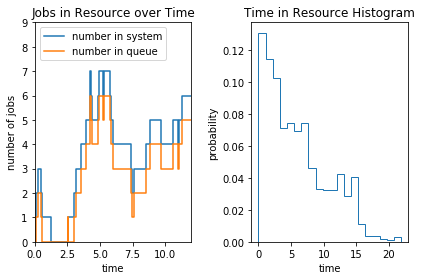

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, tight_layout=True)
insys = dc.in_systems.data()
inque = dc.in_queues.data()
axs[0].step(*zip(*insys), where='post', label="number in system")
axs[0].step(*zip(*inque), where='post', label="number in queue")
axs[0].set_xlim([0,12])
axs[0].set_ylim([0,9])
axs[0].set_title('Jobs in Resource over Time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('number of jobs')
axs[0].legend(loc='upper left')

st = dc.system_times.data()
axs[1].hist(st, bins=20, density=True, histtype='step')
axs[1].set_title('Time in Resource Histogram')
axs[1].set_xlabel('time')
axs[1].set_ylabel('probability')

plt.show()

Resource, store, and mailbox in simulus require different attributes for the DataCollectors. The following shows the attributes accepted for resources:

| Resource Attributes    | Type    | data collected    |
| :--------------------- | :------ | :---------------- |
| **arrivals** | `timemarks` | time of job arrivals
| **services** | `timemarks` | time of jobs entering services |
| **reneges** | `timemarks` | time of jobs reneging from queue |
| **departs** | `timemarks` | time of jobs departing from system |
| **inter_arrivals** | `dataseries` | job inter-arrival time |
| **queue_times** | `dataseries` | time of jobs in queue before servicing |
| **renege_times** | `dataseries` | time of jobs in queue before reneging |
| **service_times** | `dataseries` | time of jobs in service |
| **system_times** | `dataseries` | time of jobs in system |
| **in_systems** | `timeseries` | number of jobs in system |
| **in_services** | `timeseries` | number of jobs in service |
| **in_queues** | `timeseries` | number of jobs in queue |

The stores accept different DataCollector attributes. The available attributes are shown below:

| Store Attributes    | Type    | data collected    |
| :------------------ | :------ | :---------------- |
| **puts** | `timeseries` | time and amount of put requests |
| **put_times** | `dataseries` | waiting time to put items |
| **put_queues** | `timeseries` | number of processes waiting to put items |
| **gets** | `timeseries` | time and amount of get requests |
| **get_times** | `dataseries` | waiting time to get items |
| **get_queues** | `timeseries` | number of processes waiting to get items |
| **levels** | `timeseries` | storage levels |

The following example shows the previous gas station example. We use a data collector to get the gas reservoir level at the station.

In [5]:
# %load '../examples/misc/gas-dc.py'
import itertools, random, simulus

GAS_STATION_SIZE = 2000    # gas station reservoir size
GAS_PUMPS = 10             # number of gas pumps
REFUEL_THRESHOLD = 25      # min reservoir level (in %) before calling the tank truck
FUEL_TANK_SIZE = 50        # car's fuel task size
FUEL_TANK_LEVEL = [1, 15]  # min/max tank level before refueling
REFUELING_SPEED = 2        # speed of the pump
TANK_TRUCK_TIME = 300      # tank truck travel time
INTER_ARRIVAL = 5          # inter-arrival time of cars

def car_generator(sim, gas_station, fuel_pump):
    for i in itertools.count():
        sim.sleep(random.expovariate(1.0/INTER_ARRIVAL))
        sim.process(car, sim, gas_station, fuel_pump)

def car(sim, gas_station, fuel_pump):
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    gas_station.acquire() # dumb wait
    liters_required = FUEL_TANK_SIZE - fuel_tank_level
    fuel_pump.get(liters_required) # another dumb wait
    sim.sleep(liters_required / REFUELING_SPEED)
    gas_station.release()

def gas_station_control(sim, fuel_pump):
    while True:
        if fuel_pump.level/fuel_pump.capacity*100 < REFUEL_THRESHOLD:
            sim.wait(sim.process(tank_truck, sim, fuel_pump))
        sim.sleep(10)  # check every 10 seconds

def tank_truck(sim, fuel_pump):
    sim.sleep(random.expovariate(1.0/TANK_TRUCK_TIME))
    amt = fuel_pump.capacity - fuel_pump.level
    fuel_pump.put(amt)

random.seed(123)
sim = simulus.simulator()
gas_station = sim.resource(GAS_PUMPS)
dc = simulus.DataCollector(levels='timeseries(all)')
fuel_pump = sim.store(GAS_STATION_SIZE, GAS_STATION_SIZE, collect=dc)
sim.process(gas_station_control, sim, fuel_pump)
sim.process(car_generator, sim, gas_station, fuel_pump)
sim.run(until=1000)
dc.report(sim.now)


levels (timeseries): samples=145
  data=[(0, 2000), (0.26892196695146375, 1957), (0.7250413937714464, 1921)] ...
  rate = 0.145
  mean = 1009.81
  stdev = 578.789
  var = 334997
  min = 18
  max = 2000
  avg_over_time=391.148


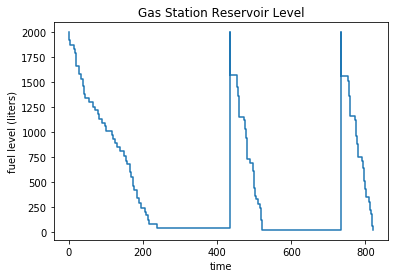

In [6]:
import matplotlib.pyplot as plt
levels = dc.levels.data()
plt.step(*zip(*levels), where='post')
plt.title('Gas Station Reservoir Level')
plt.xlabel('time')
plt.ylabel('fuel level (liters)')
plt.show()

The above plot shows the that the station seems to have a problem that the reservoir is too small to hold the enough gas. Most of the time the gas station would run dry.

Mailboxes also accept attributes for data collectors. They are listed below:

| Mailbox Attributes    | Type    | data collected    |
| :-------------------- | :------ | :---------------- |
| **arrivals** | `timemarks` | time of message arrivals |
| **retrievals** | `timemarks` | time of message retrieval requests |
| **messages** | `timeseries` | number of messages in mailbox |

A mailbox can have more than one partitions. In that case, one can use a separate data collector for each partition. In the default case, there's only one partition, so one needs only to use one data collector. In the following, we show the example we used previously to illustrate the difference between receiving one message and receiving all messages from a mailbox. Rather than using a callback function to show the messages stored at the mailbox, we simply use a data collector with the `messages` attribute. We then plot the number of messages in the mailbox and see how it grows and shrinks over time.

In [7]:
# %load '../examples/misc/delivery-dc.py'
import simulus

from random import seed, expovariate, randint
seed(12345)

def generate():
    num = 0
    while True:
        sim.sleep(expovariate(1))
        for _ in range(randint(1,5)): # send a bunch
            mb.send(num)
            num += 1

def get_one():
    while True:
        sim.sleep(1)
        msg = mb.recv(isall=False)

def get_all():
    while True:
        sim.sleep(5)
        msgs = mb.recv()

sim = simulus.simulator()
dc = simulus.DataCollector(messages='timeseries(all)')
mb = sim.mailbox(collect=dc)
sim.process(generate)
sim.process(get_one)
sim.process(get_all)
sim.run(22)
dc.report(sim.now)


messages (timeseries): samples=102
  data=[(0.5389162854563174, 1), (1, 0), (2.254685865860081, 1)] ...
  rate = 4.63636
  mean = 7.54902
  stdev = 6.46351
  var = 41.777
  min = 0
  max = 25
  avg_over_time=6.45331


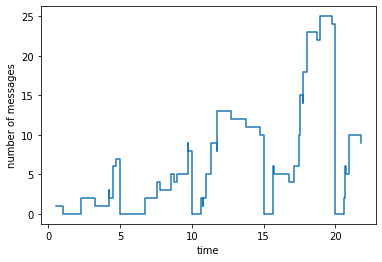

In [8]:
import matplotlib.pyplot as plt

msgs = dc.messages.data()
plt.step(*zip(*msgs), where='post')
plt.xlabel('time')
plt.ylabel('number of messages')
plt.show()
